In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch" # alternatively you can use jax or tensorflow as the backend (see installation instructions in keras documentation)
import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # helpful for splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler, MinMaxScaler # helpful for scaling data to be between 0 and 1 or have a mean of 0 and standard deviation of 1


In [4]:
file_path = '/Users/ctychen/Desktop/N3AS/spectrum_data/'
#reloading data
parameters = np.concatenate([np.load(file_path + "atm_retr_params_12800_"+str(i)+".npy") for i in range(12)])
spectra_set = np.concatenate([np.load(file_path + "atm_retr_data_12800_"+str(i)+".npy") for i in range(12)])

#take the log of the spectra - seems like this helped a lot with feature identification
spectra_set = np.log(spectra_set)

parameters = parameters[~np.isnan(spectra_set).any(axis=1)]
spectra_set = spectra_set[~np.isnan(spectra_set).any(axis=1)]

print(parameters.shape)
print(spectra_set.shape)

(153590, 16)
(153590, 947)


In [5]:
n_samples = parameters.shape[0]
n_features = 947 #this is really arbitrary

# ATTEMPT 2: 
#maybe instead of using the standardscaler (or minmaxscaler), we might have to normalize the spectra on our own
#we could do the same (log(flux) - min / (max - min)) normalization that we did for the spectra
#and keep in mind that we are already working with log(flux) spectra. 
max_log_flux = np.max(spectra_set, axis=1)
min_log_flux = np.min(spectra_set, axis=1)
spectra_set = (spectra_set - min_log_flux[:, np.newaxis])/(max_log_flux - min_log_flux)[:, np.newaxis]

#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(parameters, spectra_set, test_size=0.2)

In [6]:
inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
x = keras.layers.Dense(512, activation="relu")(inp) 
x = keras.layers.Dense(256, activation="relu")(x) 
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(32, activation="relu")(x) # (bottleneck layer)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(256, activation="relu")(x) 
x = keras.layers.Dense(512, activation="relu")(x)
out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons
autoencoder = keras.models.Model(inp, out) # create model with input and output layers

# compile model
autoencoder.compile(optimizer="adam", loss="mean_squared_error") # use adam optimizer and mean squared error loss function

# print model summary
autoencoder.summary()

# train model with training data and validate with testing data (early stopping is used to avoid overfitting)
history = autoencoder.fit(y_train, y_train, epochs=500, batch_size=32, validation_data=(y_test, y_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # this stops training if the validation loss does not decrease for 5 epochs to avoid overfitting

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 947)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       485,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 947)            │       485,811 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320,787 (5.04 MB)

 Trainable params: 1,320,787 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0092 - val_loss: 9.6334e-04
Epoch 2/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 7.4542e-04 - val_loss: 4.6078e-04
Epoch 3/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 5.2363e-04 - val_loss: 4.2064e-04
Epoch 4/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 4.7508e-04 - val_loss: 3.7174e-04
Epoch 5/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 4.0352e-04 - val_loss: 4.0054e-04
Epoch 6/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 3.9348e-04 - val_loss: 2.7004e-04
Epoch 7/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 3.4521e-04 - val_loss: 3.8314e-04
Epoch 8/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 3.3609e-04 - val_loss: 3.0797e-04
Epoch 9/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 3.1187e-04 - val_loss: 3.1420e-04
Epoch 10/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 3.0408e-04 - val_loss: 3.1457e-04
Epoch 11/500
3840/38

In [7]:
dir = '/Users/ctychen/Desktop/N3AS/models/'
autoencoder.save(dir+"autoencoder_512_256_128_64_32_64_128_256_512.keras")

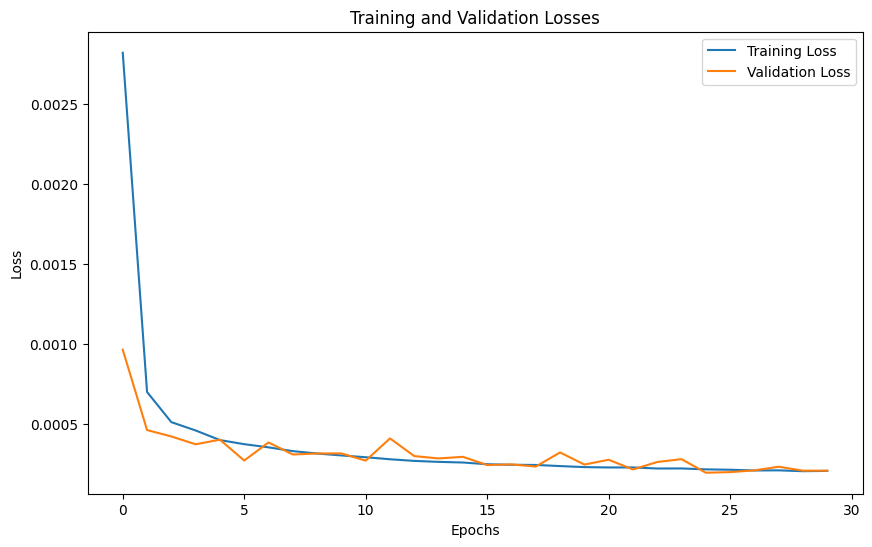

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Training and Validation Losses')
plt.legend()
plt.show()
figdir = '/Users/ctychen/Desktop/N3AS/figures/'
plt.savefig(figdir + 'autoencoder_loss_512_256_128_64_32.png')

960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8646e-04
Test Loss: 0.00020677087013609707
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step


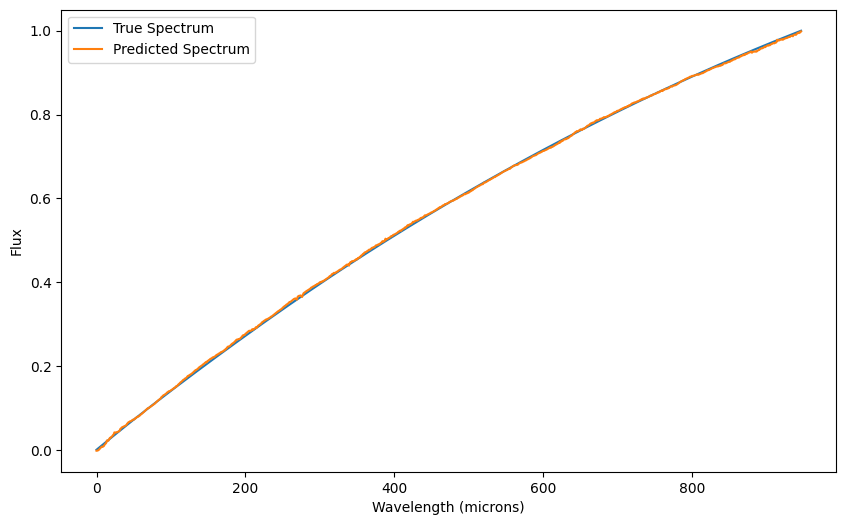

In [9]:
#try evaluating the model with testing data
loss = autoencoder.evaluate(y_test, y_test)
print(f'Test Loss: {loss}')

#example predictions
y_pred = autoencoder.predict(y_test)

wavelengths = np.linspace(0.95, 2.45, len(y_test[0]))

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label="True Spectrum")
plt.plot(y_pred[0], label="Predicted Spectrum")
plt.legend()
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux")
plt.show()

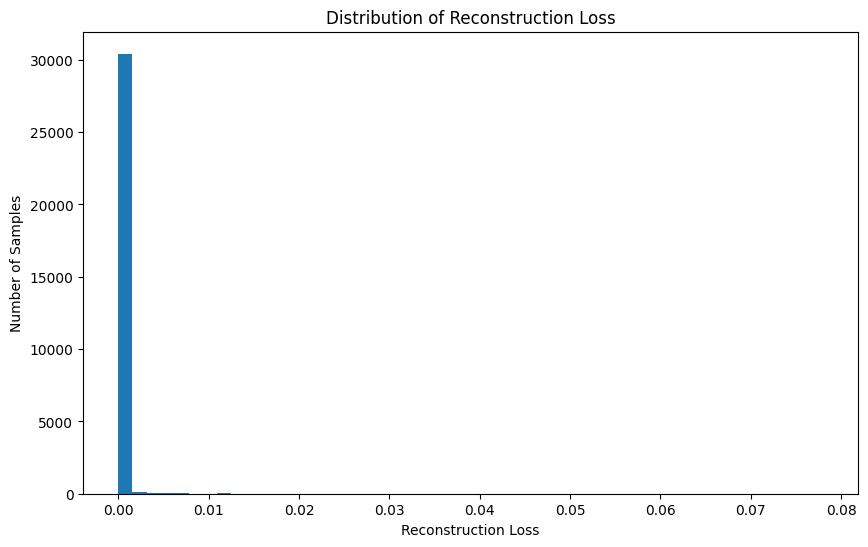

Mean Reconstruction Loss: 0.00020677564869684003
Max Reconstruction Loss: 0.07799256686010912
Min Reconstruction Loss: 3.3975262491485356e-06


In [10]:
reconstruction_loss = np.mean((y_pred - y_test)**2, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Loss")
plt.show()

print(f'Mean Reconstruction Loss: {np.mean(reconstruction_loss)}')
print(f'Max Reconstruction Loss: {np.max(reconstruction_loss)}')
print(f'Min Reconstruction Loss: {np.min(reconstruction_loss)}')

960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[30553 14131 22688 14845 28087 28027 27958 12694 25932 14786]


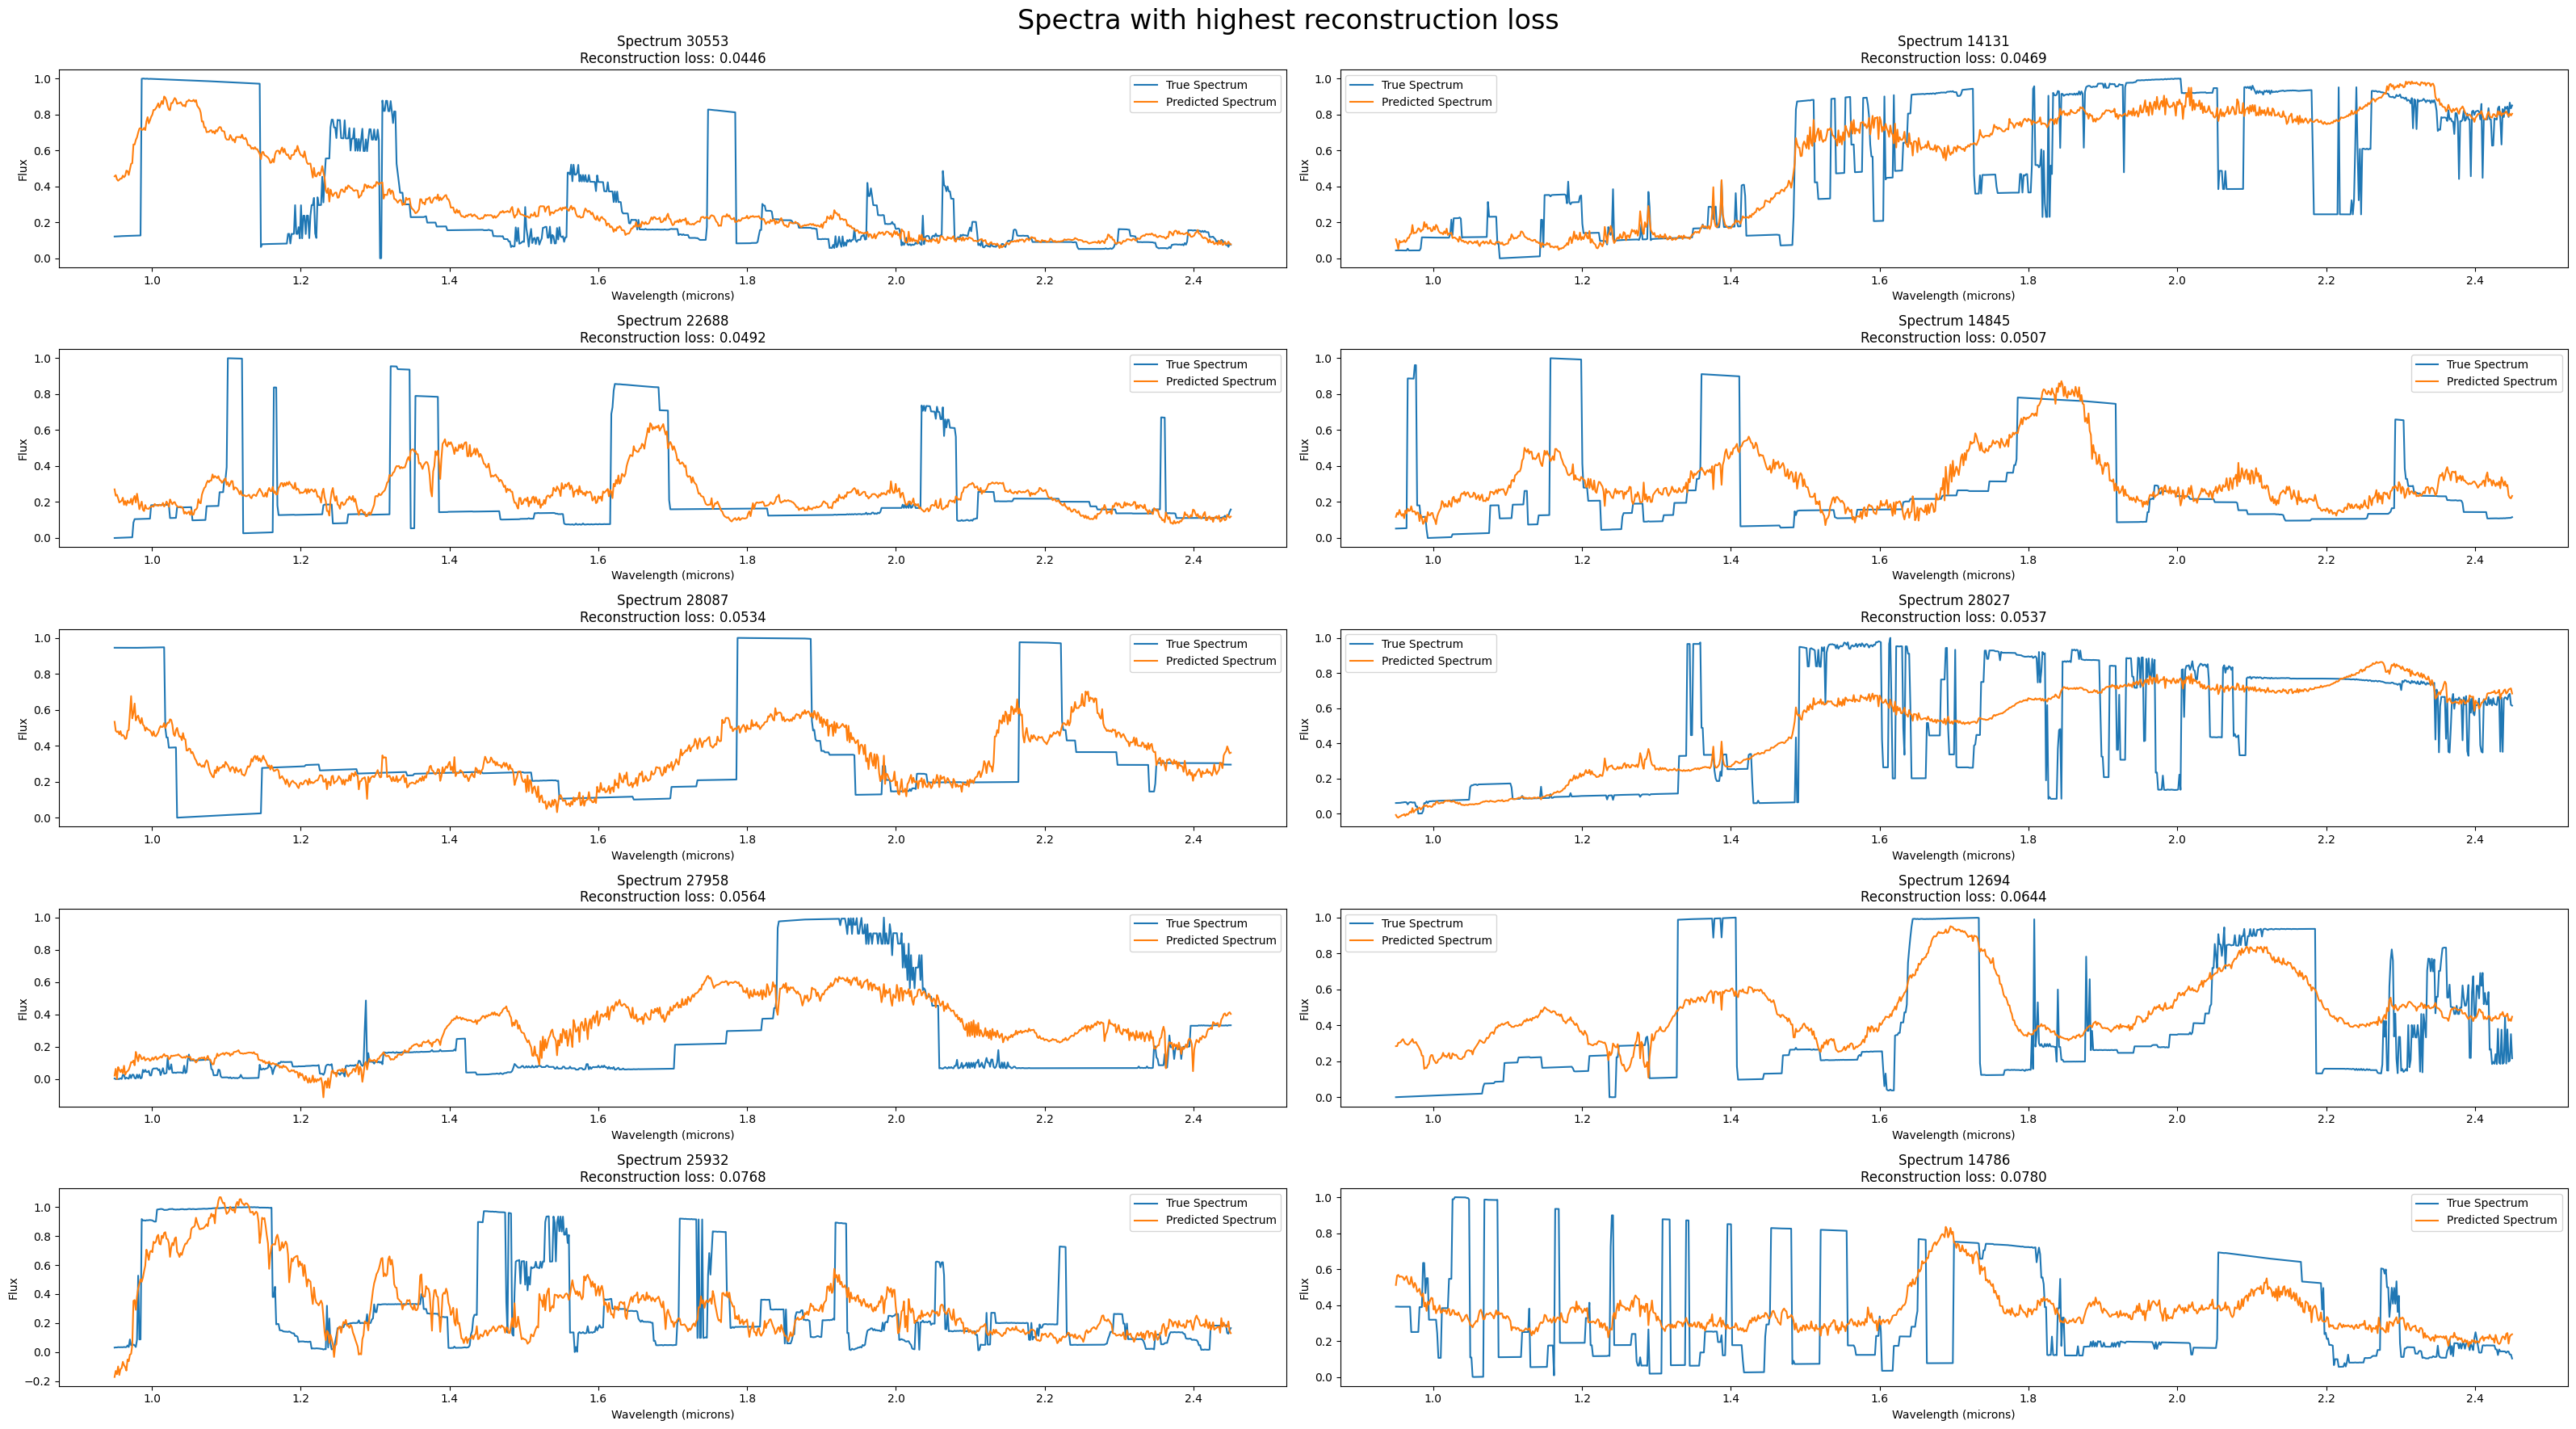

<Figure size 640x480 with 0 Axes>

In [11]:
y_pred = autoencoder.predict(y_test)
reconstruction_loss = np.mean((y_pred - y_test)**2, axis=1)
wavelengths = np.linspace(0.95, 2.45, len(y_test[0]))

worst_indices = np.argsort(reconstruction_loss)[-10:]
print(worst_indices)

fig, axs = plt.subplots(5, 2, figsize=(16*2, 9*2))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()
plt.savefig('/Users/ctychen/Desktop/N3AS/figures/10_spectra_with_highest_reconstruction_loss_512_256_128_64_32_64_128_256_512.png')

[ 8790  7925 16359 18978 21385 20008  2372 11759  4958  9437 18485 28103
 25818  8816  4597 14747  1421 30381 19785  9603 17815 24842  1843  1742
  2709 21193 26385 18552 21739 29001  8300 18223 19525  8977 16291 16219
 30026  9946 23108  7336 13811  4931 12865 15448 13085  7994  9573 18729
 27906 26113     4 26755  1832  7377  6941 13159 28210 29106 23523 14585
 24360 17868 22695  8565  8886 26486 18502 27181 27975 13235 24795 17123
 22161  8229 17274 10256  1656 18500 22673 13404 26460 25832  7916  8982
 11825  1981 28638 14494 29659 19781 30553 14131 22688 14845 28087 28027
 27958 12694 25932 14786]


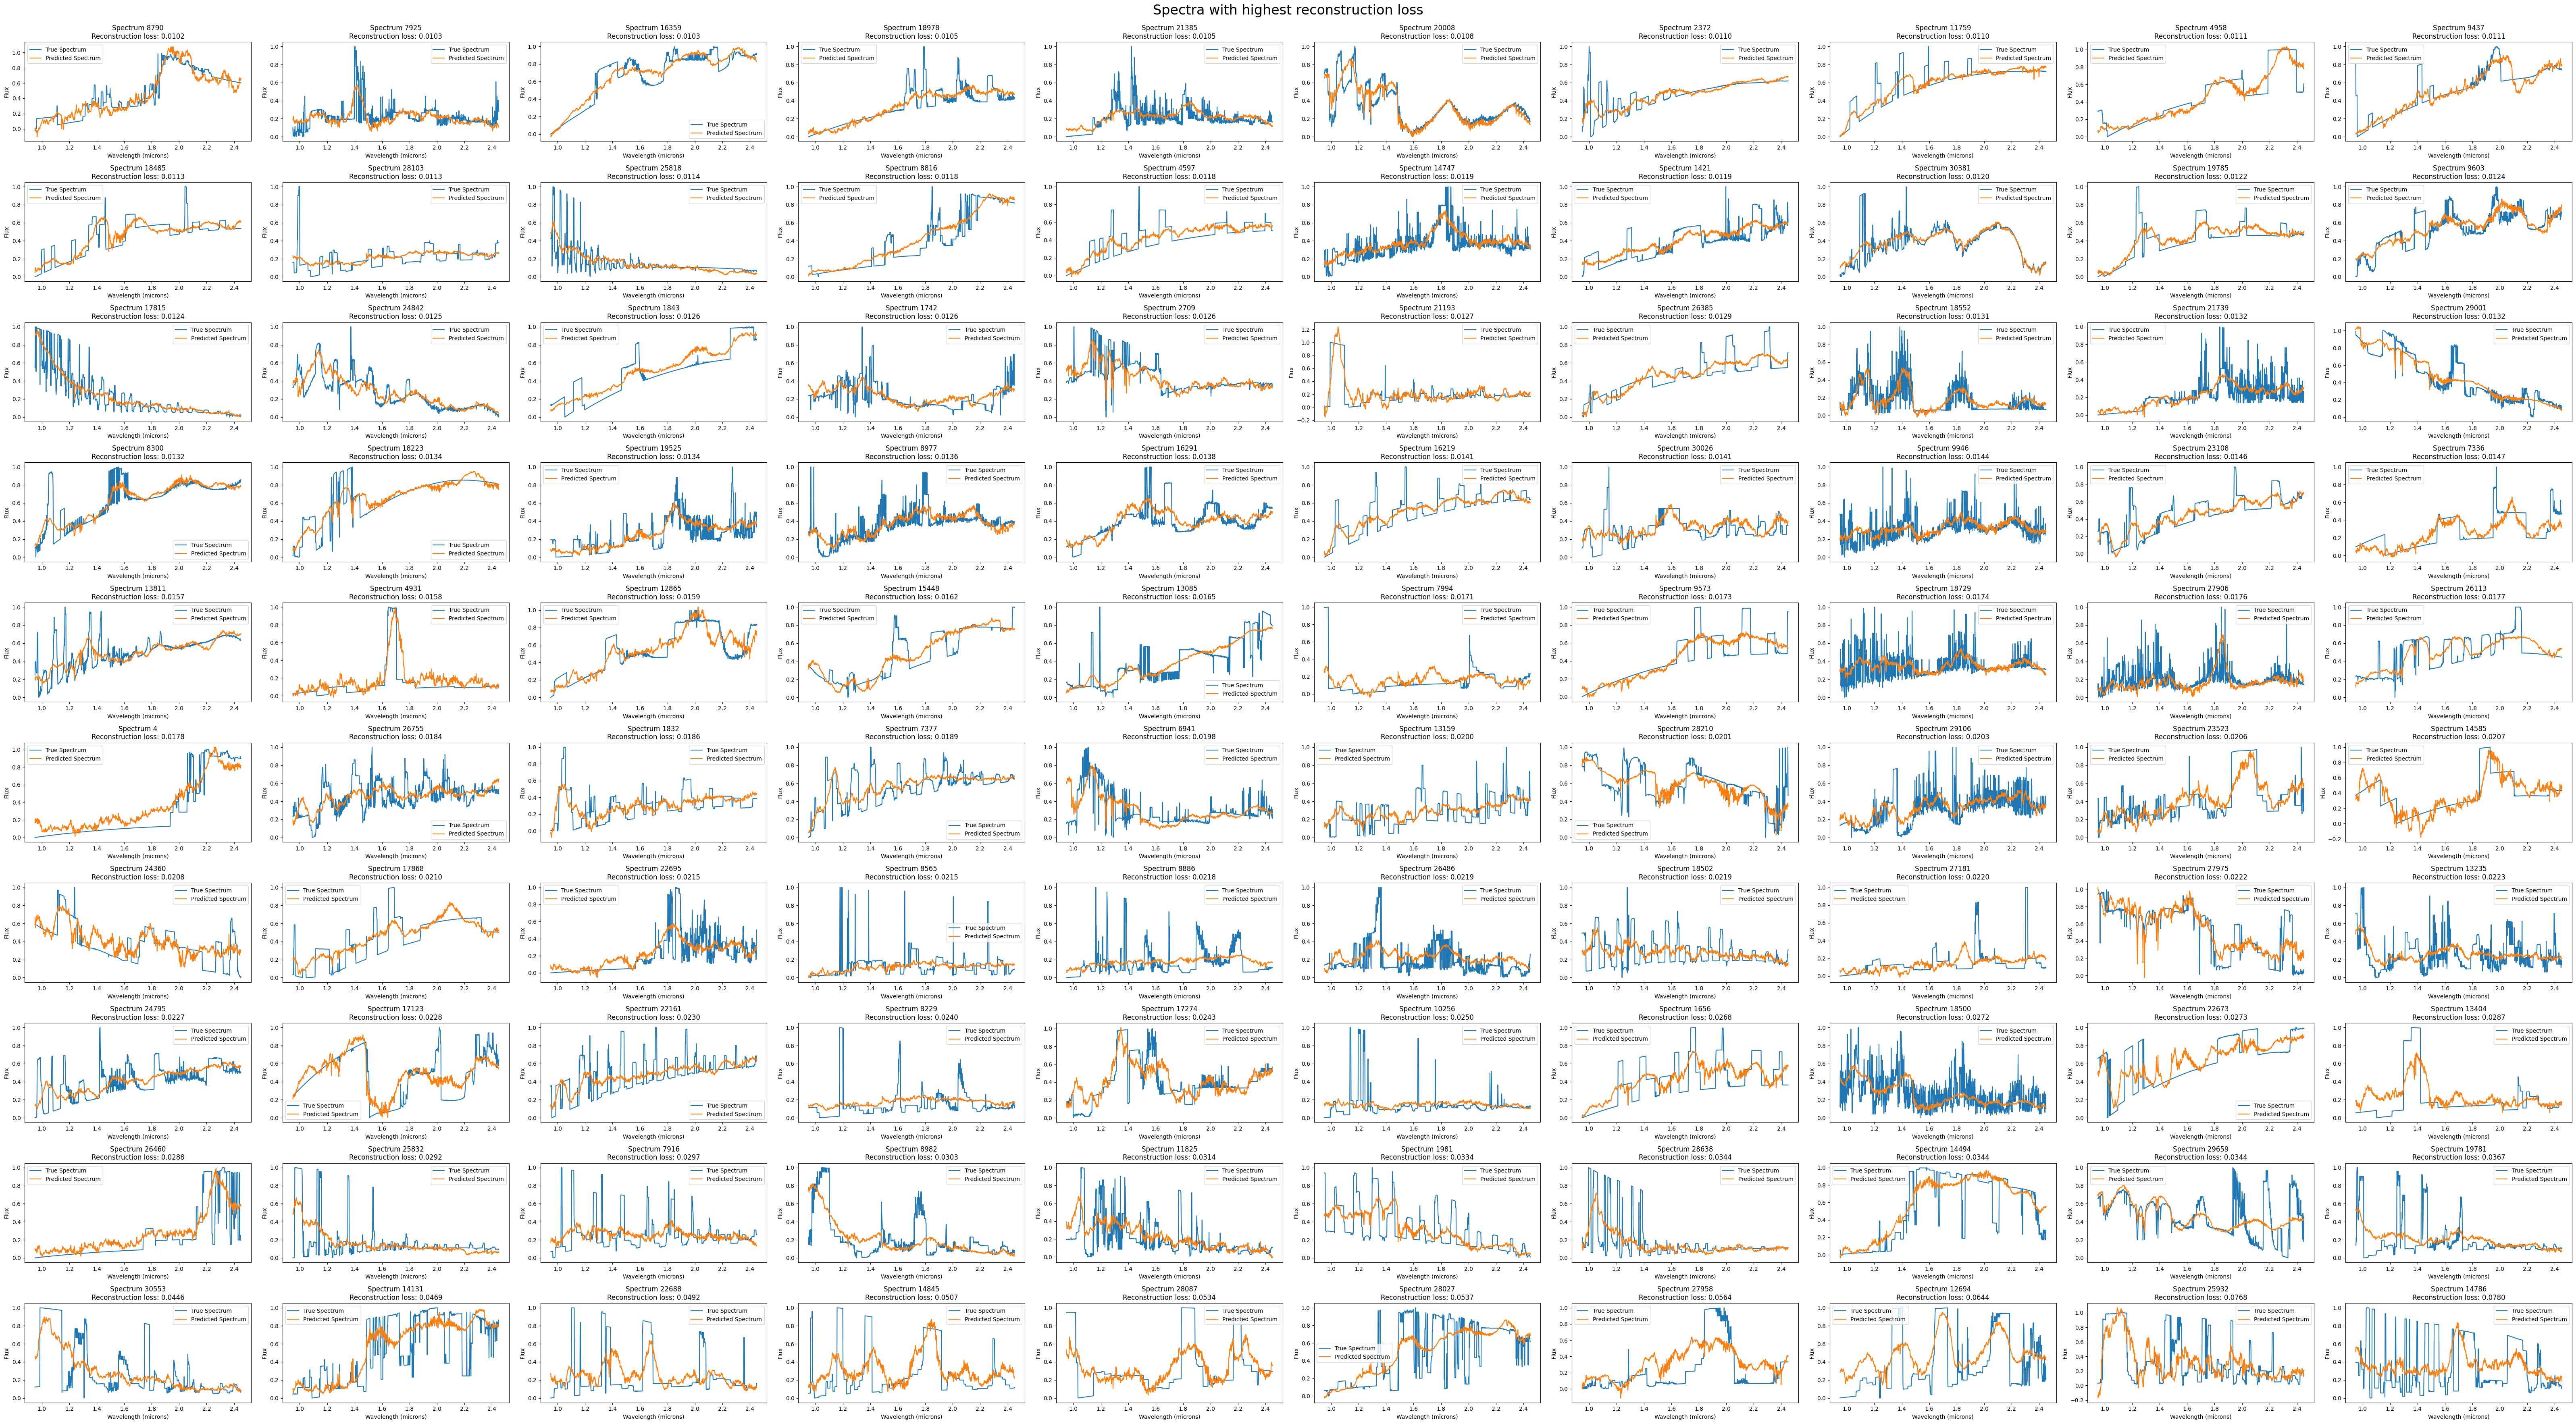

<Figure size 640x480 with 0 Axes>

In [12]:
worst_indices = np.argsort(reconstruction_loss)[-100:]
# print(worst_indices)

fig, axs = plt.subplots(10, 10, figsize=(16*4, 9*4))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()
plt.savefig('/Users/ctychen/Desktop/N3AS/figures/100_spectra_with_highest_reconstruction_loss_512_256_128_64_32_64_128_256_512.png')

In [ ]:
worst_indices = np.argsort(reconstruction_loss)[-400:]
fig, axs = plt.subplots(20, 20, figsize=(16*1.5*4, 9*1.5*4))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
# plt.show()
plt.savefig('/Users/ctychen/Desktop/N3AS/figures/400_spectra_with_highest_reconstruction_loss_512_256_128_64_32_64_128_256_512.png')

In [ ]:
# # id = 15410

# plt.figure(figsize=(10, 6))
# plt.plot(wavelengths, y_test[15409], label="True Spectrum", alpha=0.5)
# plt.plot(wavelengths, y_pred[15409], label="Predicted Spectrum")
# plt.legend()
# plt.xlabel("Wavelength (microns)")
# plt.ylabel("Flux")
# plt.title(f'Spectrum {15410}\nReconstruction loss: {reconstruction_loss[15409]:.4f}')
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(wavelengths, y_test[15409], label="True Spectrum")
# plt.plot(wavelengths, y_pred[15409], label="Predicted Spectrum")
# plt.legend()
# plt.xlabel("Wavelength (microns)")
# plt.ylabel("Flux")
# plt.title(f'Spectrum {15410}\nReconstruction loss: {reconstruction_loss[15409]:.4f}')
# plt.xlim(1.8, 2.4)
# plt.show()

In [ ]:
#attempt 6:
# 512-128-64-128-512 from prev tests
inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
x = keras.layers.Dense(512, activation="relu")(inp) 
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x) # (bottleneck layer)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons
autoencoder = keras.models.Model(inp, out) # create model with input and output layers

# compile model
autoencoder.compile(optimizer="adam", loss="mean_squared_error") # use adam optimizer and mean squared error loss function

# print model summary
autoencoder.summary()

# train model with training data and validate with testing data (early stopping is used to avoid overfitting)
history = autoencoder.fit(y_train, y_train, epochs=500, batch_size=32, validation_data=(y_test, y_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # this stops training if the validation loss does not decrease for 5 epochs to avoid overfitting

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
y_pred = autoencoder.predict(y_test)
reconstruction_loss = np.mean((y_pred - y_test)**2, axis=1)
wavelengths = np.linspace(0.95, 2.45, len(y_test[0]))
worst_indices = np.argsort(reconstruction_loss)[-10:]
print(worst_indices)

fig, axs = plt.subplots(5, 2, figsize=(16*2, 9*2))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()

In [ ]:
worst_indices = np.argsort(reconstruction_loss)[-100:]

fig, axs = plt.subplots(10, 10, figsize=(16*4, 9*4))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()

In [ ]:
worst_indices = np.argsort(reconstruction_loss)[-400:]

fig, axs = plt.subplots(20, 20, figsize=(16*1.5*4, 9*1.5*4))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
# plt.show()
plt.savefig('/Users/ctychen/Desktop/N3AS/figures/400_spectra_with_highest_reconstruction_loss_512_128_64_128_512.png')

In [ ]:
#attempt 7:
# 512-256-64-256-512
inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
x = keras.layers.Dense(512, activation="relu")(inp) 
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x) # (bottleneck layer)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons
autoencoder = keras.models.Model(inp, out) # create model with input and output layers

# compile model
autoencoder.compile(optimizer="adam", loss="mean_squared_error") # use adam optimizer and mean squared error loss function

# print model summary
autoencoder.summary()

# train model with training data and validate with testing data (early stopping is used to avoid overfitting)
history = autoencoder.fit(y_train, y_train, epochs=500, batch_size=32, validation_data=(y_test, y_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # this stops training if the validation loss does not decrease for 5 epochs to avoid overfitting

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Training and Validation Losses')
plt.legend()
# plt.show()
plt.savefig('/Users/ctychen/Desktop/N3AS/figures/training_and_validation_losses_512_256_64_256_512.png')

In [ ]:
y_pred = autoencoder.predict(y_test)
reconstruction_loss = np.mean((y_pred - y_test)**2, axis=1)
wavelengths = np.linspace(0.95, 2.45, len(y_test[0]))

worst_indices = np.argsort(reconstruction_loss)[-100:]

fig, axs = plt.subplots(10, 10, figsize=(16*4, 9*4))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.savefig('/Users/ctychen/Desktop/N3AS/figures/100_spectra_with_highest_reconstruction_loss_512_256_64_256_512.png')

In [ ]:
worst_indices = np.argsort(reconstruction_loss)[-400:]

fig, axs = plt.subplots(20, 20, figsize=(16*1.5*4, 9*1.5*4))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.savefig('/Users/ctychen/Desktop/N3AS/figures/400_spectra_with_highest_reconstruction_loss_512_256_64_256_512.png')